In [1]:
%matplotlib inline
import glob
import h5py
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import skopi as sk

import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output
from sklearn.decomposition import PCA, IncrementalPCA

import os
import sys
sys.path.append('../src/')

In [2]:
spi_dataset="/sdf/scratch/fpoitevi/skopi/6q5u/0.4/8.00/saveHDF5_parallel.h5"
spi_data = h5py.File(spi_dataset, 'r')
geom_path=f'/sdf/home/a/anassb/skopi/examples/input/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'
det = sk.PnccdDetector(geom=geom_path)

In [4]:
spi_data.keys()

<KeysViewHDF5 ['intensities', 'orientations', 'photons', 'pixel_index_map', 'pixel_position_reciprocal', 'positions', 'volume']>

In [16]:
n_images, channels = spi_data['photons'].shape[:2]
d1, d2 = (1024, 1040)
n_batches = 100
batch_size = n_images // n_batches
batch_index = np.arange(n_images).reshape(n_batches, batch_size)

n_comp = 10

sub_ratio = 4
sub_d1 = d1 // sub_ratio
sub_d2 = d2 // sub_ratio

sub_index_1 = sub_ratio * np.arange(sub_d1)
sub_index_2 = sub_ratio * np.arange(sub_d2)

# Incremental PCA

In [17]:
ipca = IncrementalPCA(n_components=n_comp)

for index in tqdm(batch_index) :
    batch = det.assemble_image_stack_batch(spi_data['photons'][index])[:, sub_index_1][:,:, sub_index_2]
    ipca.partial_fit(batch.reshape(batch_size, sub_d1 * sub_d2))

100%|██████████| 100/100 [1:11:17<00:00, 42.77s/it]


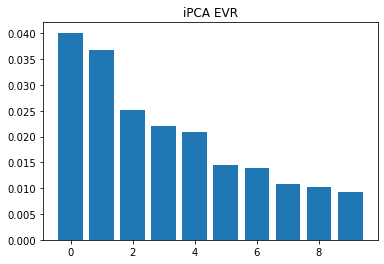

In [6]:
fig = plt.figure(figsize=(6, 4))
plt.bar(np.arange(n_comp), ipca.explained_variance_ratio_)
plt.title('iPCA EVR')
plt.show()

In [7]:
fig.savefig('../images/spi_evr.png')

In [8]:
n_samples = 1000

resized = ipca.transform(det.assemble_image_stack_batch(spi_data['photons'][:n_samples])[:, sub_index_1][:,:, sub_index_2].reshape(n_samples, sub_d1 * sub_d2))

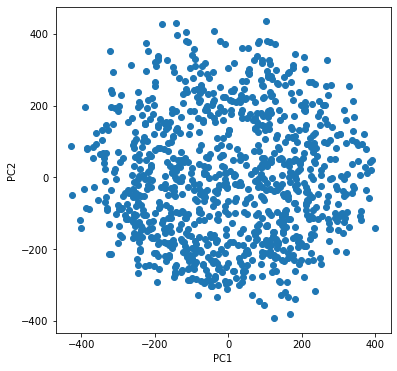

In [66]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(resized[:, 0], resized[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [10]:
fig.savefig('../images/spi_ipca.png')

# Fourier transform

In [54]:
n_batches = 100
batch_size = n_images // n_batches
batch_index = np.arange(n_images).reshape(n_batches, batch_size)

n_comp = 10

sub_ratio = 16
sub_d1 = d1 // sub_ratio
sub_d2 = d2 // sub_ratio

sub_index_1 = sub_ratio * np.arange(sub_d1)
sub_index_2 = sub_ratio * np.arange(sub_d2)

In [63]:
fourier_ipca = IncrementalPCA(n_components=n_comp)

for index in tqdm(batch_index) :
    batch = det.assemble_image_stack_batch(spi_data['photons'][index])[: , sub_index_1][:,:, sub_index_2]
    f_shift = np.fft.fftshift(np.fft.fft2(batch))
    spectrum = 20*np.log(np.abs(f_shift))
    fourier_ipca.partial_fit(spectrum.reshape(batch_size, sub_d1 * sub_d2))

  2%|▏         | 2/100 [01:09<57:07, 34.98s/it]/opt/anaconda/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
  2%|▏         | 2/100 [01:48<1:28:19, 54.08s/it]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [58]:
f = np.fft.fft2(det.assemble_image_stack_batch(spi_data['photons'][:2])[:, sub_index_1][:, :, sub_index_2])
f_shift = np.fft.fftshift(f)
spectrum = 20*np.log(np.abs(f_shift))


In [62]:
spectrum.dtype

dtype('float64')